In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chip-data/dataset/test/defect/D1_C513.jpg
/kaggle/input/chip-data/dataset/test/defect/D0_C157.jpg
/kaggle/input/chip-data/dataset/test/defect/D1_C131.jpg
/kaggle/input/chip-data/dataset/test/defect/D1_C139.jpg
/kaggle/input/chip-data/dataset/test/defect/D0_C8.jpg
/kaggle/input/chip-data/dataset/test/defect/D2_C221.jpg
/kaggle/input/chip-data/dataset/test/defect/D2_C215.jpg
/kaggle/input/chip-data/dataset/test/defect/D0_C48.jpg
/kaggle/input/chip-data/dataset/test/defect/D1_C35.jpg
/kaggle/input/chip-data/dataset/test/defect/D0_C10.jpg
/kaggle/input/chip-data/dataset/test/defect/D1_C5.jpg
/kaggle/input/chip-data/dataset/test/defect/D0_C126.jpg
/kaggle/input/chip-data/dataset/test/defect/D0_C153.jpg
/kaggle/input/chip-data/dataset/test/defect/D1_C221.jpg
/kaggle/input/chip-data/dataset/test/defect/D2_C137.jpg
/kaggle/input/chip-data/dataset/test/defect/D1_C21.jpg
/kaggle/input/chip-data/dataset/test/defect/D0_C148.jpg
/kaggle/input/chip-data/dataset/test/defect/D1_C107.jpg


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [5]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [6]:
# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "/kaggle/input/chip-data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [7]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

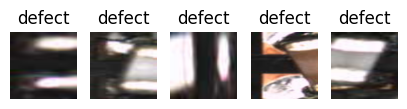

In [8]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [9]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [10]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
from torchvision.models import VGG19_Weights
model=models.vgg19(weights=VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 222MB/s] 


In [12]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [14]:
# Modify the final fully connected layer to match the dataset classes

num_classes=len(train_dataset.classes)
in_features=model.classifier[-1].in_features
model.classifier[-1]=nn.Linear(in_features,num_classes)

In [15]:
model=model.to(device)

In [16]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) # Only optimize classifier parameters

In [20]:
## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=30):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name: K SANTHAN KUMAR")
    print("Register Number: 212223240065")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


Epoch [1/30], Train Loss: 0.0391, Validation Loss: 1.8505
Epoch [2/30], Train Loss: 0.9530, Validation Loss: 0.5416
Epoch [3/30], Train Loss: 0.1061, Validation Loss: 2.4778
Epoch [4/30], Train Loss: 0.1694, Validation Loss: 1.1782
Epoch [5/30], Train Loss: 0.2217, Validation Loss: 2.5908
Epoch [6/30], Train Loss: 0.2981, Validation Loss: 0.6281
Epoch [7/30], Train Loss: 0.2006, Validation Loss: 0.5691
Epoch [8/30], Train Loss: 0.0000, Validation Loss: 1.2226
Epoch [9/30], Train Loss: 0.0442, Validation Loss: 0.7273
Epoch [10/30], Train Loss: 0.0842, Validation Loss: 0.7074
Epoch [11/30], Train Loss: 0.0023, Validation Loss: 0.8928
Epoch [12/30], Train Loss: 0.0000, Validation Loss: 0.8049
Epoch [13/30], Train Loss: 0.0000, Validation Loss: 0.8091
Epoch [14/30], Train Loss: 0.0887, Validation Loss: 2.3096
Epoch [15/30], Train Loss: 0.4040, Validation Loss: 5.4414
Epoch [16/30], Train Loss: 0.3531, Validation Loss: 1.1820
Epoch [17/30], Train Loss: 0.0897, Validation Loss: 1.2758
Epoch 

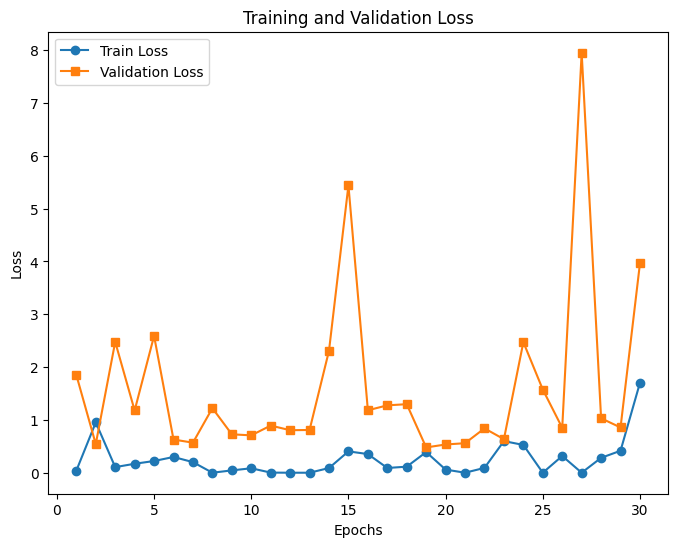

In [21]:
train_model(model,train_loader,test_loader)

In [22]:
## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name: K SANTHAN KUMAR")
    print("Register Number: 212223240065")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Test Accuracy: 0.9421
Name: K SANTHAN KUMAR
Register Number: 212223240065


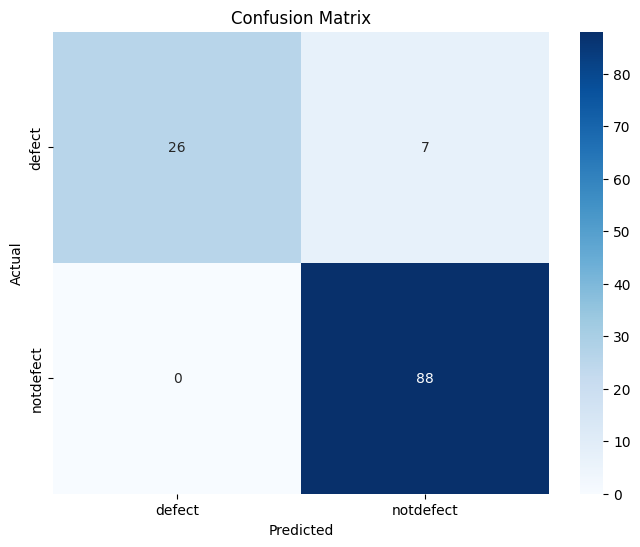

Classification Report:
              precision    recall  f1-score   support

      defect       1.00      0.79      0.88        33
   notdefect       0.93      1.00      0.96        88

    accuracy                           0.94       121
   macro avg       0.96      0.89      0.92       121
weighted avg       0.95      0.94      0.94       121



In [23]:
test_model(model, test_loader)

In [24]:
## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        # The image is already a tensor, just add batch dimension and send to device
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes  # Get class labels

    # Display the image
    # Need to convert the image back to PIL format for display
    image_to_display = transforms.ToPILImage()(image)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()

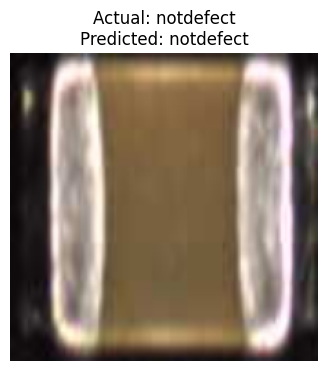

In [25]:
predict_image(model, image_index=55, dataset=test_dataset)


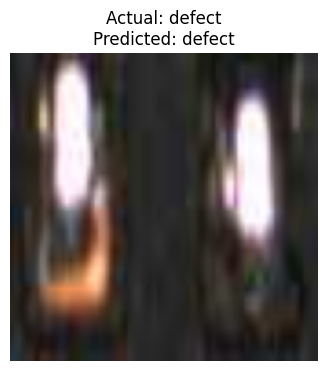

In [26]:
predict_image(model, image_index=25, dataset=test_dataset)